***
### Stretch
***

# Import from Github

In [1]:
# !git clone https://github.com/ihsaan-ullah/fair-universe
# %cd fair-universe/starting_kit

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
from sys import path
from copy import copy, deepcopy
import warnings
warnings.filterwarnings("ignore")

## Directories

In [3]:
model_dir = 'sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

### Add directories to path

In [4]:
path.append(model_dir) 
path.append(problem_dir)
path.append(score_dir)
path.append("../Data_Generator")

***
# 0 - Generate Data
***

**Imports**

In [5]:
from data_loader import get_settings_from_json
from data_generator_new import DataGenerator

In [6]:
data_gen_settings = get_settings_from_json('data_jsons/stretch')
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.load_settings()
    data_gen.generate_data()
    data_gen.save_data(directory="sample_data", file_index=index+1)
    

***
# 1 - Import Data
***

In [7]:
from data_io import load_data, show_data_statistics, write

In [8]:
data_name = 'fair_universe_challenge'
data_dir = 'sample_data' 

In [9]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data
[*] train data dir :  sample_data/train/data
[*] train labels dir :  sample_data/train/labels
[*] test data dir :  sample_data/test/data
[*] test labels dir :  sample_data/test/labels
[*] settings dir :  sample_data/settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




**Data Visualization**

In [10]:
from visualize import (
    visualize_decicion_boundary,
    visualize_augmented_data,
    visualize_data,
    visualize_clocks,
    visualize_score,
    visualize_roc_curves
)

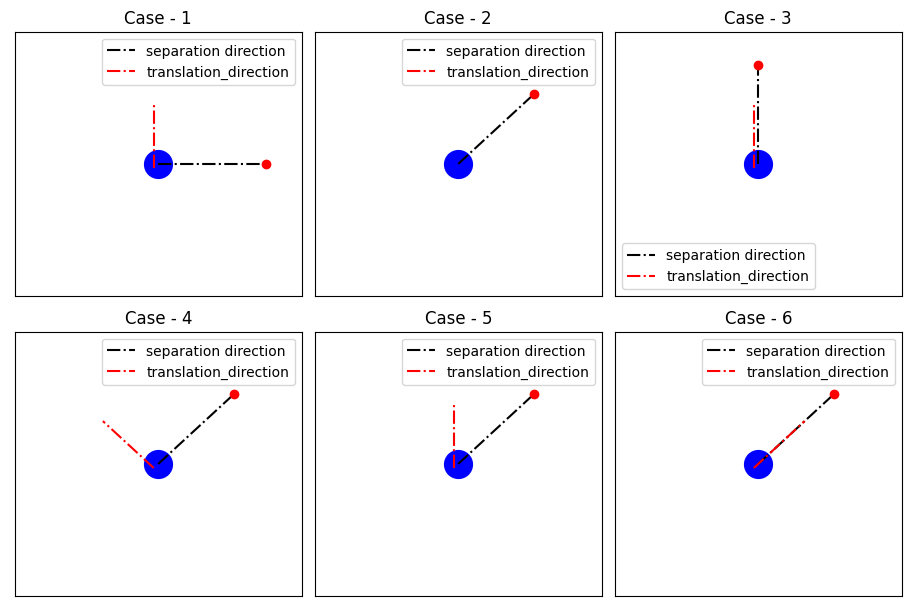

In [11]:
visualize_clocks(settings)

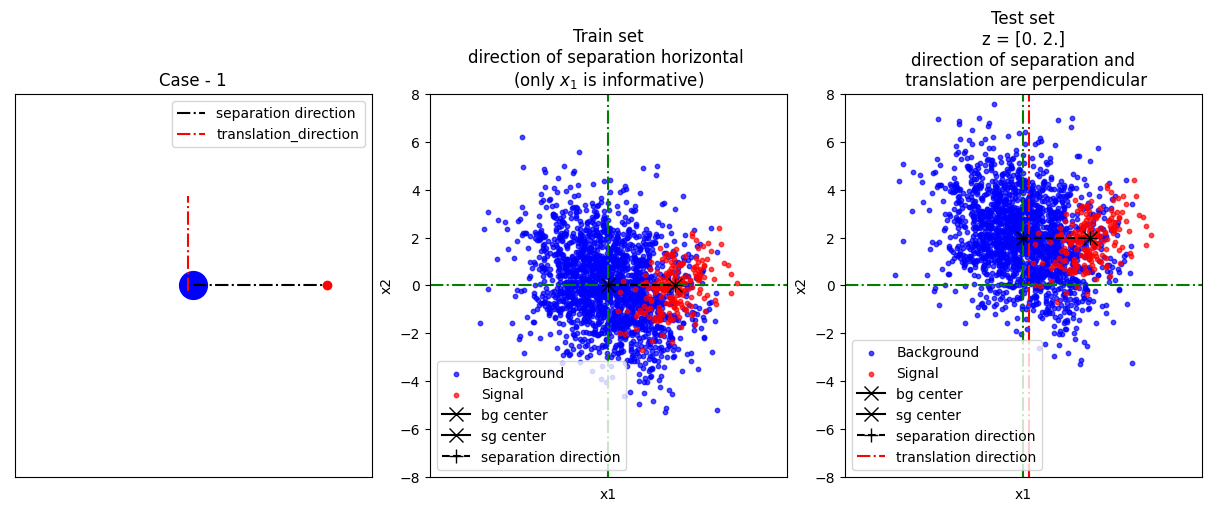

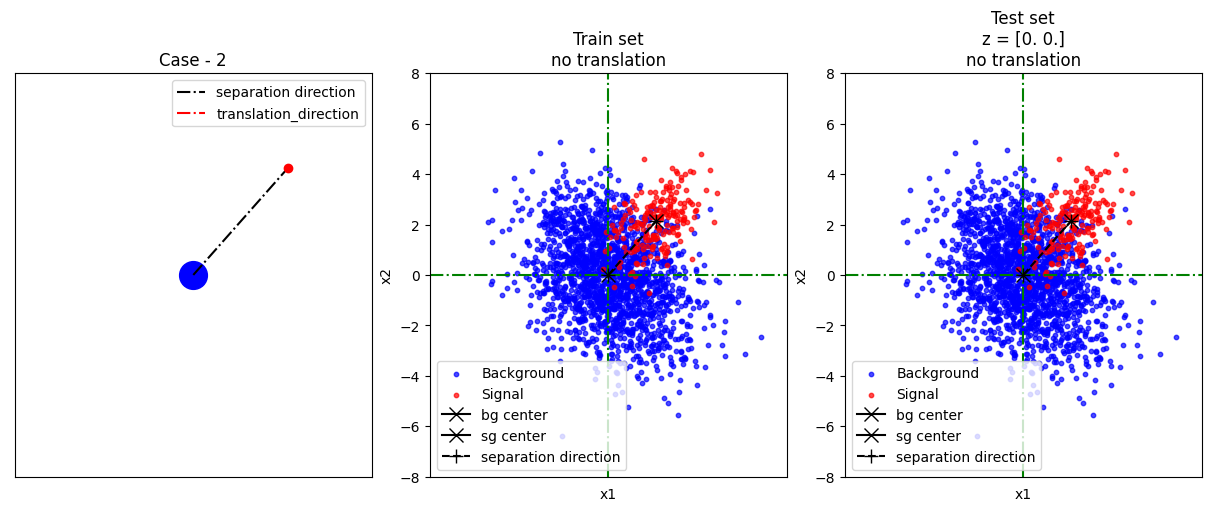

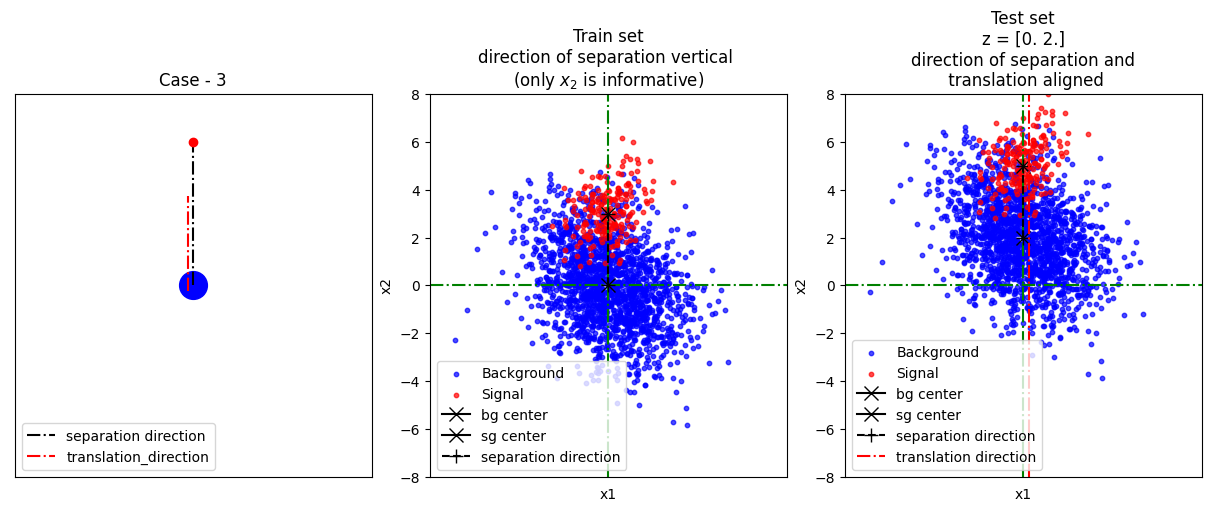

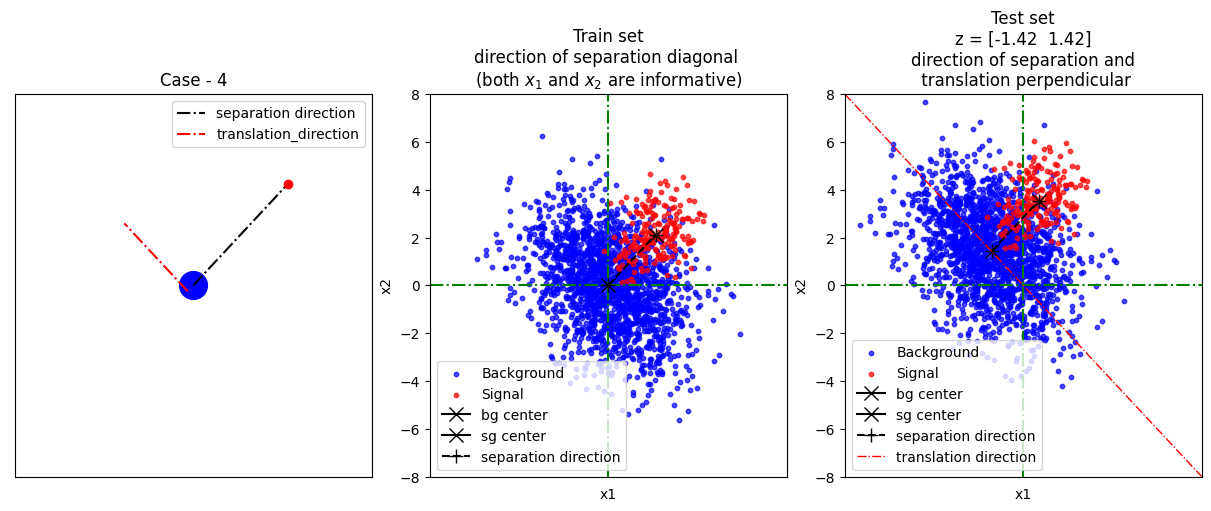

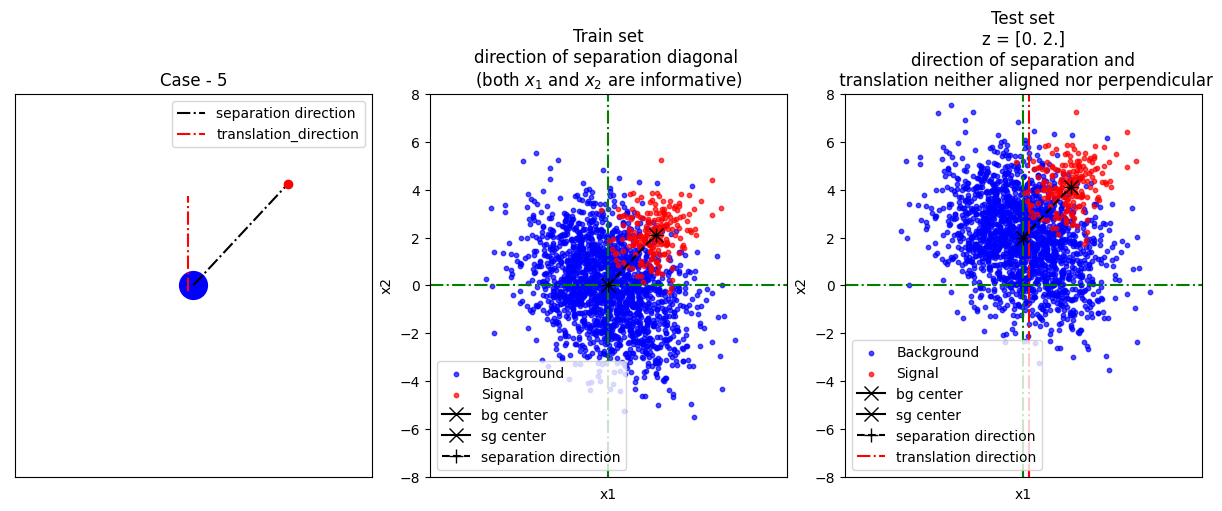

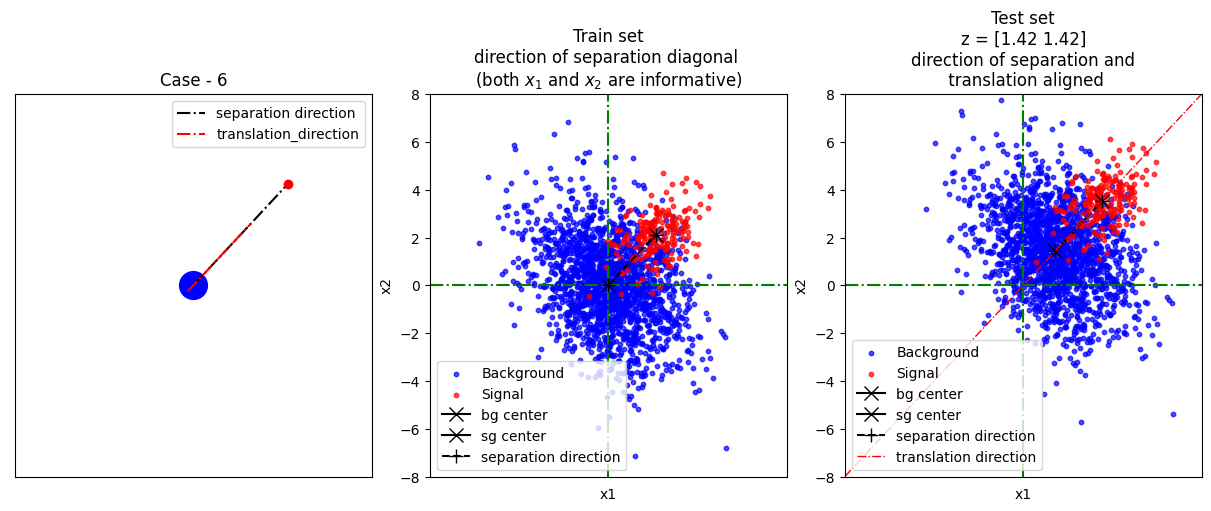

In [12]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])

***
# 2 - Data Augmentation
***

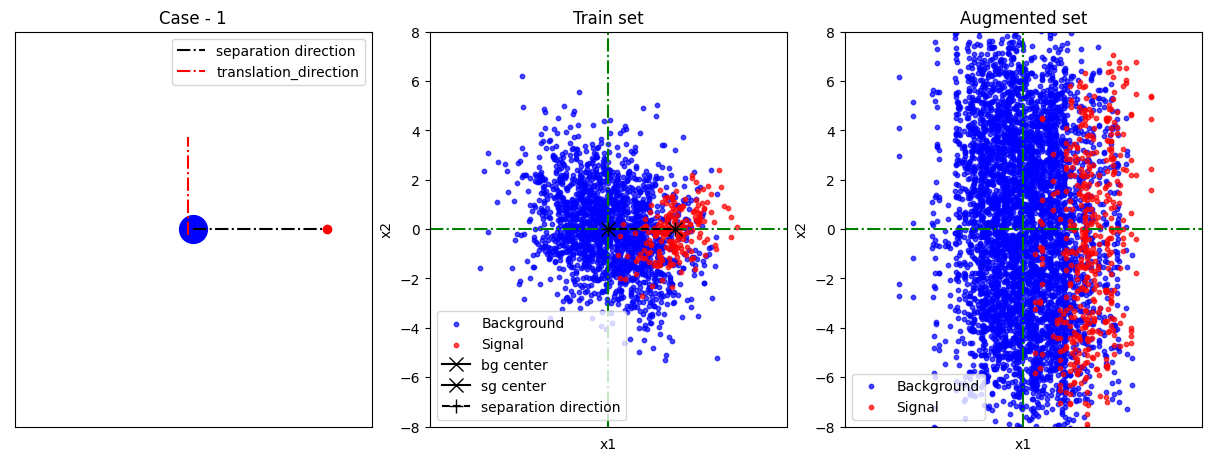

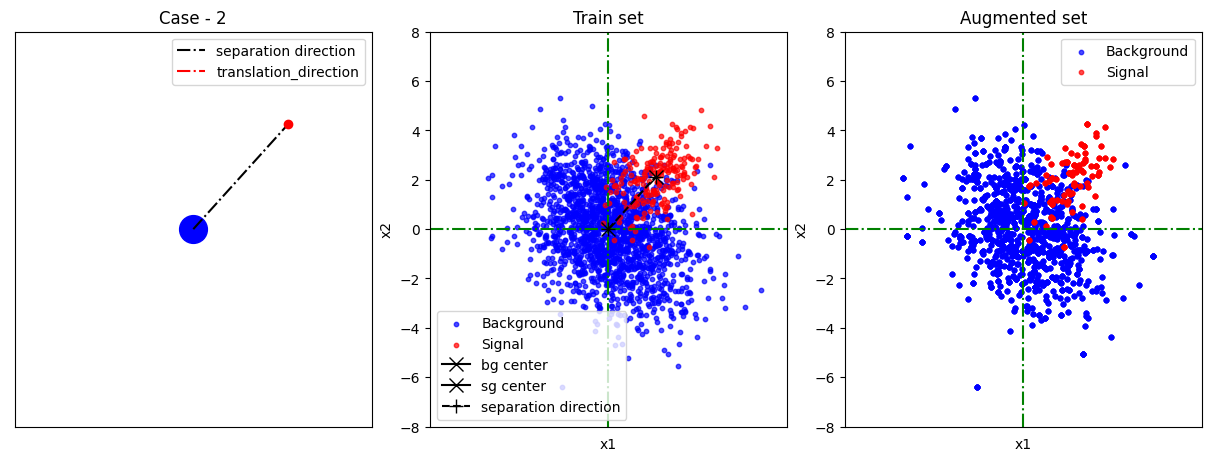

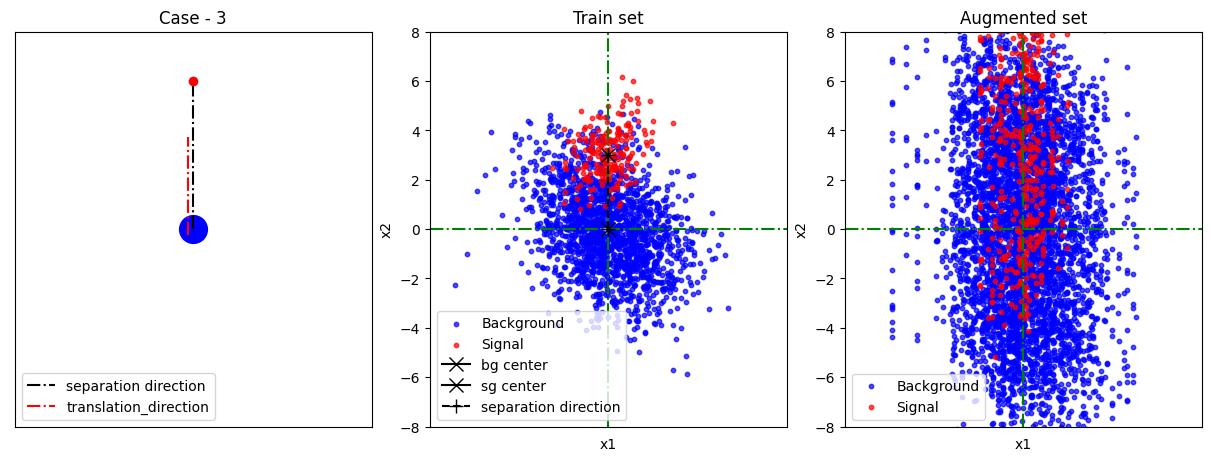

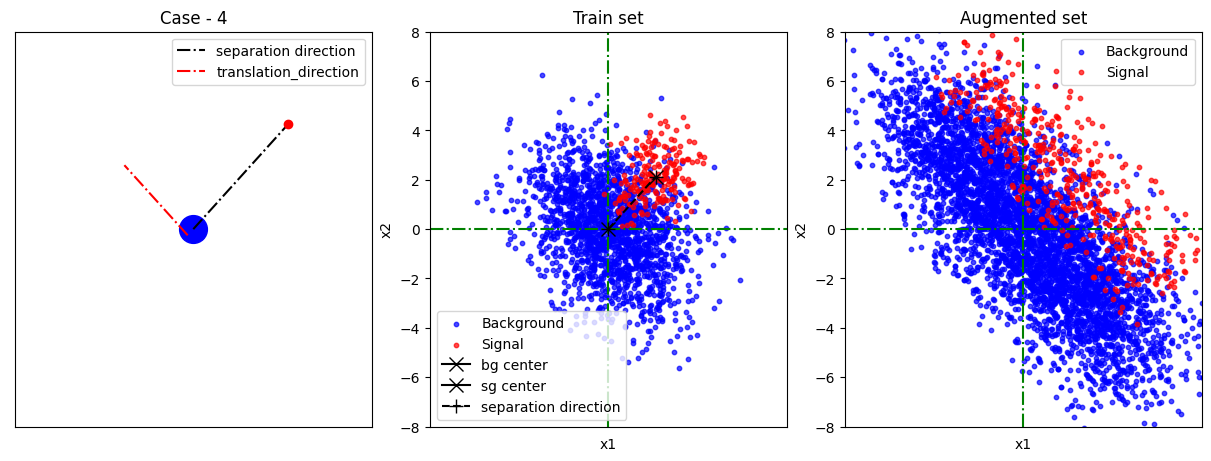

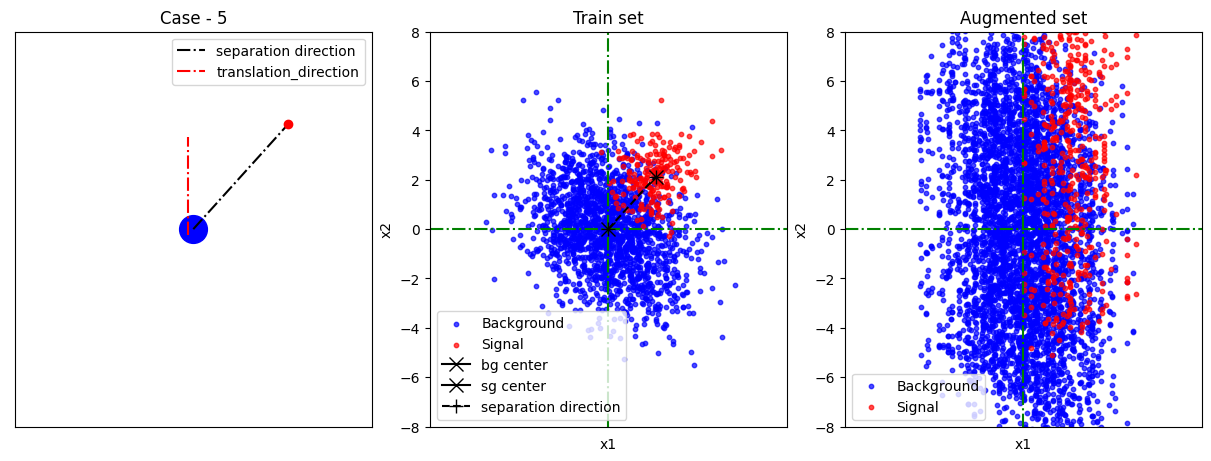

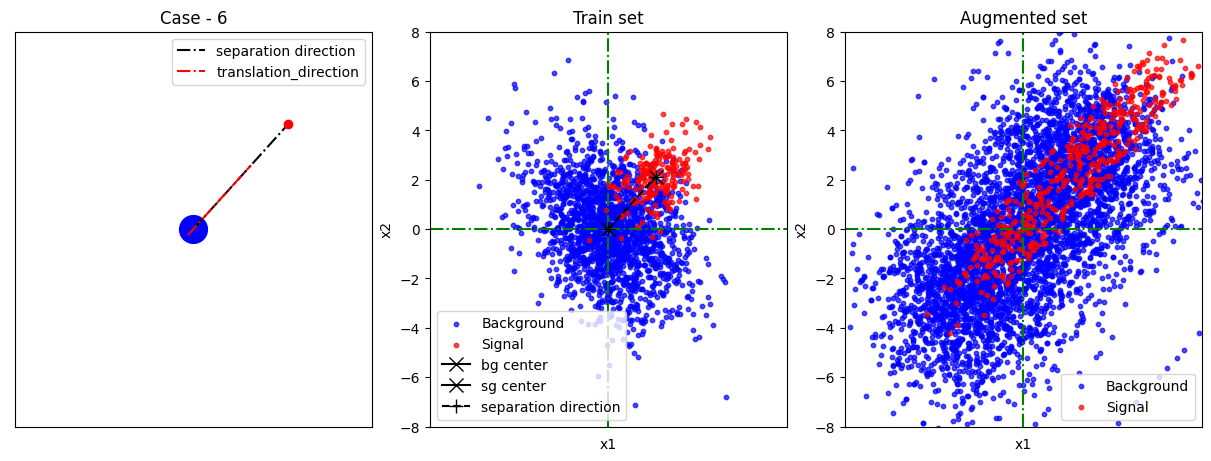

In [13]:
from augment_data import get_augmented_data

augmented_sets = []
for i, _ in enumerate(train_sets):
    augmented_set = get_augmented_data(train_sets[i],  test_sets[i])
    visualize_augmented_data(settings[i], train_sets[i], augmented_set)
    augmented_sets.append(augmented_set)

***
# 3 - Preprocessing
***

In [ ]:
train_sets_preprocessed, test_sets_preprocessed = [], []
for train_set, test_set in zip(train_sets, test_sets):
    
    train_mean = np.mean(train_set["data"]).values
    test_mean = np.mean(test_set["data"]).values

    translation = test_mean - train_mean

    train_sets_preprocessed.append({
        "data" : train_set["data"] - translation, 
        "labels" : train_set["labels"] 
    })

    test_sets_preprocessed.append({
        "data" : test_set["data"] - translation, 
        "labels" : test_set["labels"] 
    })


***
# 4 - Baselines
***

In this section, we introduce the following baselines:

1. Constant model
2. NB plain
3. NB preprocessing
4. LDA plain
5. RR plain
6. NB data augmentation
7. LDA data augmentation
8. RR data augmentatio

**Import Model and Scoring function**

In [ ]:
from model import Model
from metric import auc_metric, bac_metric

**Model Names and settings**

In [ ]:
model_settings = [
    {"display_name" : "constant model", "model_name": "Constant", "preprocessing" : False, "preprocessing_method" : "translation",  "data_augmentation" : False, "data_augmentation_type":"translation"},
    {"display_name" : "NB plain", "model_name": "NB", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : False, "data_augmentation_type":"translation"},
    {"display_name" : "NB preprocessing", "model_name": "NB", "preprocessing" : True, "preprocessing_method" : "translation", "data_augmentation" : False, "data_augmentation_type":"translation"},
    {"display_name" : "LDA plain", "model_name": "LDA", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : False, "data_augmentation_type":"translation"},
    {"display_name" : "RR plain", "model_name": "RR", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : False, "data_augmentation_type":"translation"},
    {"display_name" : "NB data augmentation", "model_name": "NB", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : True, "data_augmentation_type":"translation"},
    {"display_name" : "LDA data augmentation", "model_name": "LDA", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : True, "data_augmentation_type":"translation"},
    {"display_name" : "RR data augmentation", "model_name": "RR", "preprocessing" : False, "preprocessing_method" : "translation", "data_augmentation" : True, "data_augmentation_type":"translation"}
]

**Train and Test**  

- Load Data
- Train Model
- Get Predictions
- Get Score
- Get Metric Scores
- Save Predictions
- Save Scores


In [ ]:
#---------------------------------
# Load Data
#---------------------------------
# Train set
X_Trains = [train_set["data"] for train_set in train_sets]
Y_Trains = [train_set["labels"] for train_set in train_sets]

# Test set
X_Tests = [test_set["data"] for test_set in test_sets]
Y_Tests = [test_set["labels"] for test_set in test_sets]


print("############################################")
print("### Training Program")
print("############################################")

#---------------------------------
# Loop over model settings
#---------------------------------
results = []
for model_setting in model_settings:

    print("\n--------------------------------------------")
    print("[*] Model : {} --- Preprocessing: {} --- Data Augmentation: {}".format(model_setting["model_name"], model_setting["preprocessing"], model_setting["data_augmentation"]))
    print("--------------------------------------------")
    #---------------------------------
    # Predictions Directory
    #---------------------------------
    # result directory 
    predictions_dir = os.path.join(result_dir, model_setting["model_name"])
    # create result directory if not created
    if not os.path.exists(predictions_dir):
        os.mkdir(predictions_dir) 

    #---------------------------------
    # Loop over datasets
    #---------------------------------
    trained_models = []
    Y_hat_trains, Y_hat_score_trains = [], []
    Y_hat_tests, Y_hat_score_tests = [], []
    auc_trains, auc_tests, bac_trains, bac_tests = [],[],[],[]
    for index, _ in enumerate(X_Trains):

        print("\n\tDataset : {}".format(index+1))
        print("\t----------------")

    
        # model_name 
        trained_model_name = model_dir + model_setting["model_name"]

        #---------------------------------
        # Load Model
        #---------------------------------
        print("\t[*] Loading Model")
        model = Model(
            model_setting["model_name"],
            X_Trains[index],
            Y_Trains[index],
            X_Tests[index],
            model_setting["preprocessing"],
            model_setting["preprocessing_method"],
            model_setting["data_augmentation"],
            model_setting["data_augmentation_type"]
        )
        # Load Trained Model 
        # model = model.load(trained_model_name) 

        #---------------------------------
        # Train Model
        #---------------------------------
        # Train model if not trained
        print("\t[*] Training Model")
        if not(model.is_trained):
            model.fit() 

        #---------------------------------
        # Get Predictions
        #---------------------------------
        print("\t[*] Get Predictions")
        Y_hat_trains.append(model.predict(X_Trains[index], preprocess=False))
        Y_hat_tests.append(model.predict())

            
        #---------------------------------
        # Get Scores/Proba
        #---------------------------------
        print("\t[*] Get Scores")
        Y_hat_score_trains.append(model.decision_function(X_Trains[index], preprocess=False))
        Y_hat_score_tests.append(model.decision_function())

        trained_models.append(model)

        #---------------------------------
        # Get Metric Scores
        #---------------------------------
        print("\t[*] Computing Scores using AUC and BAC")

        
        auc_trains.append(round(auc_metric(Y_Trains[index], Y_hat_score_trains[-1]), 2))
        auc_tests.append(round(auc_metric(Y_Tests[index], Y_hat_score_tests[-1]), 2))
        bac_trains.append(round(bac_metric(Y_Trains[index], Y_hat_trains[-1]), 2))
        bac_tests.append(round(bac_metric(Y_Tests[index], Y_hat_tests[-1]), 2))



        #---------------------------------
        # Save Predictions
        #---------------------------------
        print("\t[*] Saving Predictions and Scores")
        # prediction file name
        prediction_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".predictions")
        prediction_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".predictions")

        # score file name
        score_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".scores")
        score_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".scores")
        
        # save prediction
        write(prediction_name_train, Y_hat_score_trains[-1])
        write(prediction_name_test, Y_hat_score_tests[-1])

        # save score
        write(score_name_train, Y_hat_score_trains[-1])
        write(score_name_test, Y_hat_score_tests[-1])
    


    #---------------------------------
    # Average Scores
    #---------------------------------

    train_auc_mean = round(np.mean(auc_trains), 2)
    test_auc_mean = round(np.mean(auc_tests), 2)
    train_bac_mean = round(np.mean(bac_trains), 2)
    test_bac_mean = round(np.mean(bac_tests), 2)


    #---------------------------------
    # Error Bars
    #---------------------------------
    # between-task-variance =  sigma^2/n
    # within-task-variance ~= A(1-A) / 2*N_signals, A = AUC or BAC

    ps = 1 - settings[index]["p_b"]
    total_events = settings[index]["total_number_of_events"] 
    N_signals = ps*total_events*2
    
    train_auc_between_task_variance =  np.var(auc_trains)/len(auc_trains)
    train_auc_within_task_variance = (train_auc_mean*(1-train_auc_mean))/N_signals

    test_auc_between_task_variance =  np.var(auc_tests)/len(auc_tests)
    test_auc_within_task_variance = (test_auc_mean*(1-test_auc_mean))/N_signals

    train_bac_between_task_variance =  np.var(bac_trains)/len(bac_trains)
    train_bac_within_task_variance = (train_bac_mean*(1-train_bac_mean))/N_signals

    test_bac_between_task_variance =  np.var(bac_tests)/len(bac_tests)
    test_bac_within_task_variance = (test_bac_mean*(1-test_bac_mean))/N_signals
    

    train_auc_err = round(np.sqrt(train_auc_between_task_variance + train_auc_within_task_variance), 2)
    test_auc_err = round(np.sqrt(test_auc_between_task_variance + test_auc_within_task_variance), 2)
    train_bac_err = round(np.sqrt(train_bac_between_task_variance + train_bac_within_task_variance), 2)
    test_bac_err = round(np.sqrt(test_bac_between_task_variance + test_bac_within_task_variance), 2)



    

    results.append({
        "trained_models" : trained_models,
        "Y_hat_trains" : Y_hat_trains,
        "Y_hat_tests" : Y_hat_tests,
        "Y_hat_score_trains" : Y_hat_score_trains,
        "Y_hat_score_tests" : Y_hat_score_tests,
        "auc_trains" : auc_trains,
        "auc_tests" : auc_tests,
        "bac_trains" : bac_trains,
        "bac_tests" : bac_tests,
        "train_auc_err" : train_auc_err,
        "test_auc_err" : test_auc_err,
        "train_bac_err" : train_bac_err,
        "test_bac_err" : test_bac_err,
        "train_auc_mean" : train_auc_mean,
        "test_auc_mean" : test_auc_mean,
        "train_bac_mean" : train_bac_mean,
        "test_bac_mean" : test_bac_mean

    })

### **Optimal Bayesian Classifier**

In [ ]:
from obc import get_OBC_predictions_score

obc_predictions, obc_scores = get_OBC_predictions_score(settings[1], X_Tests[1])

obc_auc = round(auc_metric(Y_Trains[1], obc_scores), 2)
obc_bac = round(bac_metric(Y_Tests[1], obc_predictions), 2)

***
# 5 - Decision Boundaries
***

In [ ]:
for model_s, result in zip(model_settings, results):
    if model_s["model_name"] != "Constant":
        if model_s["preprocessing"]:
            visualize_decicion_boundary(model_s["display_name"], settings, result, train_sets, test_sets_preprocessed)
        elif model_s["data_augmentation"]:
            visualize_decicion_boundary(model_s["display_name"], settings, result, augmented_sets, test_sets)
        else:
            visualize_decicion_boundary(model_s["display_name"], settings, result, train_sets, test_sets)

***
# 6 - ROC Curves
***

In [ ]:
for model_s, result in zip(model_settings, results):
    if model_s["model_name"] != "Constant":
        visualize_roc_curves(model_s["display_name"], result, settings, Y_Trains, Y_Tests)

***
# 7 - Scoring
***

In this section, we evaluate the two baselines using AUC score. AUC stands for "Area Under the Curve". And the curve under which we measure the area is the ROC curve (Receiver Operating Characteristic curve). For two-classes classification, this curve is the plot of the true positive rate (TPR) as a function of the false positive rate (FPR) for all the values of a decision threshold.

**True Positive Rate**  (**TPR**) is a synonym for recall and is therefore defined as follows:
$$
TPR = \frac{TP}{TP+FN}
$$
**False Positive Rate**  (**FPR**) is defined as follows:
$$
FPR = \frac{FP}{FP+TN}
$$

<div style="text-align: center">
<img src="https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg" width="400"/>
<br>
ROC Curve showing TPR vs. FPR at different classification thresholds
</div>

For example, if we assume that a model's output is kind of a probability (a real number between $0$ and $1$) that the input is in signal class, then you can set a threshold $t$, and decide to classify an input as signal iff the ouput probility is greater than $t$. For each value of $t$, this defines both a TPR($t$) and a FPR($t$). Then the points of the ROC curve have coordinates (FPR($t$),TPR($t$)) for all $t$ between $0$ and $1$.

<div style="text-align: center">
<img src="https://developers.google.com/static/machine-learning/crash-course/images/AUC.svg" width="400"/>
<br>
AUC (Area under the ROC Curve)
</div>

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>

Source : https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=fr

In [ ]:
train_columns = ["train_set 1", "train_set 2", "train_set 3", "train_set 4", "train_set 5", "train_set 6", "avg", "std_err"]
test_columns = ["test_set 1", "test_set 2", "test_set 3", "test_set 4", "test_set 5", "test_set 6",  "avg", "std_err"]


train_aucs, test_aucs, train_bacs, test_bacs, indexes = [],[],[],[],[]
for model_s, result in zip(model_settings, results):
    indexes.append(model_s["display_name"])

    

    train_aucs.append(copy(result["auc_trains"]))
    train_aucs[-1].extend([result["train_auc_mean"], result["train_auc_err"]])
    test_aucs.append(copy(result["auc_tests"]))
    test_aucs[-1].extend([result["test_auc_mean"], result["test_auc_err"]])
    train_bacs.append(copy(result["bac_trains"]))
    train_bacs[-1].extend([result["train_bac_mean"], result["train_bac_err"]])
    test_bacs.append(copy(result["bac_tests"]))
    test_bacs[-1].extend([result["test_bac_mean"], result["test_bac_err"]])



score_auc_df_train = pd.DataFrame(data=train_aucs, columns=train_columns, index=indexes)
score_auc_df_test = pd.DataFrame(data=test_aucs, columns=test_columns, index=indexes)
score_bac_df_train = pd.DataFrame(data=train_bacs, columns=train_columns, index=indexes)
score_bac_df_test = pd.DataFrame(data=test_bacs, columns=test_columns, index=indexes)


score_auc_df_train.to_csv("scoring_output/auc_train.csv")
score_auc_df_test.to_csv("scoring_output/auc_test.csv")
score_bac_df_train.to_csv("scoring_output/bac_train.csv")
score_bac_df_test.to_csv("scoring_output/bac_test.csv")


In [ ]:
score_auc_df_train

In [ ]:
score_auc_df_test

In [ ]:
score_bac_df_train

In [ ]:
score_bac_df_test

In [ ]:
visualize_score(score_auc_df_train, score_auc_df_test, obc_auc, "AUC Score")

In [ ]:
visualize_score(score_bac_df_train, score_bac_df_test, obc_bac, "BAC Score")

***
# 8 - Submissions
***

### Unit Testing 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

**Test Ingestion Program**

In [ ]:
!python3 $problem_dir/ingestion.py

**Test Scoring Program**

In [ ]:
!python3 $score_dir/score.py

### Prepare the submission

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'code_submission_' + the_date + '.zip'
# sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(code_submission, model_dir)
# zipdir(sample_result_submission, result_dir)
print("Submit : " + code_submission + " to the compeition: https://www.codabench.org/competitions/674/")

Sample Code Submission is generated in the directory: `fair-universe/starting_kit/`